<a href="https://colab.research.google.com/github/Dim0000n/Music-Instruments-Recognition/blob/main/Music_instrumnets_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Введение

Выбранная база данных представляет собой набор сэмплов музыкальных инструментов для распознования. Базу данных можно доступна по ссылке https://zenodo.org/record/2552860#.YJf5gLUzaUl

#Библиотеки

In [ ]:
from google.colab import files
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from IPython.display import clear_output

In [ ]:
from google.colab import  drive
drive.mount("/content/drive")

Mounted at /content/drive


#Загрузка данных

In [ ]:
#загрузка таблиц с метками классов
data_train=pd.read_csv("/content/drive/MyDrive/UAI/Audio_Processing/Ultrapro/train_post_competition.csv")
data_test=pd.read_csv("/content/drive/MyDrive/UAI/Audio_Processing/Ultrapro/test_post_competition_scoring_clips.csv")

In [ ]:
data_train.head()

,fname,label,manually_verified,freesound_id,license
0,00044347.wav,Hi-hat,0,28739,Attribution
1,001ca53d.wav,Saxophone,1,358827,Attribution
2,002d256b.wav,Trumpet,0,10897,Creative Commons 0
3,0033e230.wav,Glockenspiel,1,325017,Attribution
4,00353774.wav,Cello,1,195688,Attribution


In [ ]:
data_train.shape

(9473, 5)

In [ ]:
data_test.head()

,fname,label,usage,freesound_id,license
0,00326aa9.wav,Oboe,Private,355125,Attribution
1,0038a046.wav,Bass_drum,Private,90621,Creative Commons 0
2,007759c4.wav,Saxophone,Private,13406,Creative Commons 0
3,008afd93.wav,Saxophone,Private,358962,Attribution
4,00ae03f6.wav,Chime,Private,78203,Attribution


Прроверим количество и совпадение классов в тесотвой и проверочной выборке 

In [ ]:
data_test[data_test.fname=="00326aa9.wav"].label[0]

'Oboe'

In [ ]:
train_class=data_train.label.unique() #уникальныен классы обучающей выборки
train_class.size

41

In [ ]:
test_class=data_test.label.unique()  #уникальныен классы проерочной выборки
test_class.size

41

In [ ]:
#сортировка
train_class=np.sort(train_class)
test_class=np.sort(test_class)

In [ ]:
#проверка на совпадение
if (train_class.all()==test_class.all()):
  print("Классы совпадают")
else:
  print("Классы НЕ совпадают")

Классы совпадают


In [ ]:
#загрузка аудиофайлов

In [ ]:
!unzip -q "/content/drive/MyDrive/UAI/Audio_Processing/FSDKaggle2018.audio_train.zip" -d /content/train
!unzip -q "/content/drive/MyDrive/UAI/Audio_Processing/FSDKaggle2018.audio_test.zip" -d /content/test

In [ ]:
classes=list(train_class)  #переводим классы в list 

In [ ]:
classes

['Acoustic_guitar',
 'Applause',
 'Bark',
 'Bass_drum',
 'Burping_or_eructation',
 'Bus',
 'Cello',
 'Chime',
 'Clarinet',
 'Computer_keyboard',
 'Cough',
 'Cowbell',
 'Double_bass',
 'Drawer_open_or_close',
 'Electric_piano',
 'Fart',
 'Finger_snapping',
 'Fireworks',
 'Flute',
 'Glockenspiel',
 'Gong',
 'Gunshot_or_gunfire',
 'Harmonica',
 'Hi-hat',
 'Keys_jangling',
 'Knock',
 'Laughter',
 'Meow',
 'Microwave_oven',
 'Oboe',
 'Saxophone',
 'Scissors',
 'Shatter',
 'Snare_drum',
 'Squeak',
 'Tambourine',
 'Tearing',
 'Telephone',
 'Trumpet',
 'Violin_or_fiddle',
 'Writing']

#Обработка данных

In [ ]:
#функция извлечения признаков

def get_features (y,sr):
  chroma_stft=librosa.feature.chroma_stft(y=y,sr=sr)
  mfcc=librosa.feature.mfcc(y=y,sr=sr)

  rmse=np.mean(librosa.feature.rms(y=y))
  spec_cent=np.mean(librosa.feature.spectral_centroid(y=y,sr=sr))
  spec_bw=np.mean(librosa.feature.spectral_bandwidth(y=y,sr=sr))
  rolloff=np.mean(librosa.feature.spectral_rolloff(y=y,sr=sr))
  zcr=np.mean(librosa.feature.zero_crossing_rate(y))

  out=[]
  out.append(rmse)
  out.append(spec_cent)
  out.append(spec_bw)
  out.append(rolloff)
  out.append(zcr)

  for e in mfcc:
    out.append(np.mean(e))

  for e in chroma_stft:
    out.append(np.mean(e))

  return out

In [ ]:
#функция парсинга данных

def getData(path,df):
  amount=df.shape[0]
  xSet=[]
  ySet=[]
  counter=0
  for filename in os.listdir(path):      #сканирование по всем файлам
    songname=path+f'/{filename}'
    y,sr=librosa.load(songname,mono=True)  #загрузка файла
    out=get_features(y,sr)          #извлечение признаков
    xSet.append(out)    #добавление признаков в xTrain
    ySet.append(classes.index(df[df.fname==filename].label.values[0]))      #добавление метки жанра в yTrain
    counter+=1
    #вывод процента выполнения
    perc=round(counter/amount*100,2)
    clear_output()
    print("Выполнено {} %".format(perc))
    
  xSet=np.array(xSet)
  ySet=np.array(ySet)

  return xSet,ySet

In [ ]:
xTrain,yTrain=getData("/content/train/FSDKaggle2018.audio_train",data_train) #формируем обучающую выборку

Выполнено 100.0 %


In [ ]:
#сохраняем
np.save("xTrain",xTrain)
np.save("yTrain",yTrain)

np.save("/content/drive/MyDrive/UAI/Audio_Processing/xTrain",xTrain)
np.save("/content/drive/MyDrive/UAI/Audio_Processing/yTrain",yTrain)

In [ ]:
xTest,yTest=getData("/content/test/FSDKaggle2018.audio_test",data_test) #формируем тестовую выборку

Выполнено 100.0 %


In [ ]:
#сохраняем
np.save("xTest",xTest)
np.save("yTest",yTest)

np.save("/content/drive/MyDrive/UAI/Audio_Processing/xTest",xTest)
np.save("/content/drive/MyDrive/UAI/Audio_Processing/yTest",yTest)

In [ ]:
print("Размерность xTrain",xTrain.shape)
print("Размерность yTrain",yTrain.shape)
print("Размерность xTest",xTest.shape)
print("Размерность yTest",yTest.shape)

Размерность xTrain (9473, 37)
Размерность yTrain (9473,)
Размерность xTest (1600, 37)
Размерность yTest (1600,)


In [ ]:
#нормирование данных
scaler=StandardScaler()

scaler.fit(xTrain)
xTrain=scaler.transform(xTrain)
xTest=scaler.transform(xTest)

In [ ]:
#функция отрисовки графиков
def draw(history):
  plt.figure(figsize=(15,7))

  plt.subplot(121)       #график точности
  plt.plot(history.history["accuracy"],label="Обучающая выборка")
  plt.plot(history.history["val_accuracy"],label="Проверочная выборка")
  plt.title("Точнось модели")
  plt.xlabel("Эпохи")
  plt.ylabel("Доля верных ответов")

  plt.subplot(122)    #график ошибки
  plt.plot(history.history["loss"],label="Обучающая выборка")
  plt.plot(history.history["val_loss"],label="Проверочная выборка")
  plt.title("Ошибка модели")
  plt.xlabel("Эпохи")
  plt.ylabel("Значение ошибки")

  plt.legend()
  plt.show()

#нейронка

Epoch 1/100
474/474 [==============================] - 2s 3ms/step - loss: 2.9190 - accuracy: 0.2233 - val_loss: 1.9938 - val_accuracy: 0.4431
Epoch 2/100
474/474 [==============================] - 1s 2ms/step - loss: 2.2335 - accuracy: 0.3943 - val_loss: 1.8036 - val_accuracy: 0.5050
Epoch 3/100
474/474 [==============================] - 1s 2ms/step - loss: 2.1037 - accuracy: 0.4221 - val_loss: 1.7475 - val_accuracy: 0.5050
Epoch 4/100
474/474 [==============================] - 1s 2ms/step - loss: 2.0622 - accuracy: 0.4366 - val_loss: 1.7089 - val_accuracy: 0.5281
Epoch 5/100
474/474 [==============================] - 1s 2ms/step - loss: 1.9289 - accuracy: 0.4737 - val_loss: 1.6489 - val_accuracy: 0.5406
Epoch 6/100
474/474 [==============================] - 1s 2ms/step - loss: 1.8964 - accuracy: 0.4804 - val_loss: 1.5840 - val_accuracy: 0.5694
Epoch 7/100
474/474 [==============================] - 1s 3ms/step - loss: 1.8521 - accuracy: 0.4832 - val_loss: 1.5673 - val_accuracy: 0.5681

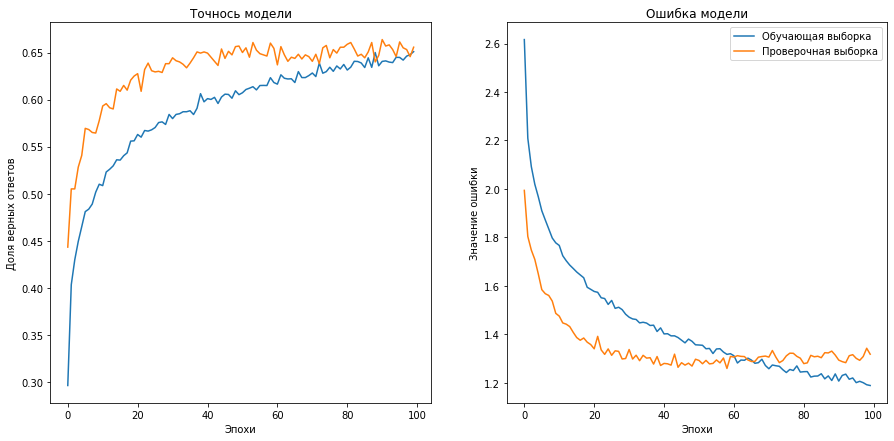

In [ ]:
#модель
model1=Sequential()
model1.add(Dense(256,activation="elu",input_shape=(37,)))
model1.add(Dropout(0.3))
model1.add(Dense(128,activation="elu"))
model1.add(Dropout(0.3))
model1.add(Dense(len(classes),activation="softmax"))

#компиляция
model1.compile(optimizer=Adam(lr=1e-3),loss="sparse_categorical_crossentropy",metrics=["accuracy"])

#обучение
history1=model1.fit(xTrain,yTrain,
                    epochs=100,batch_size=20,
                    validation_data=(xTest,yTest))

draw(history1)

Epoch 1/20
474/474 [==============================] - 2s 3ms/step - loss: 1.1491 - accuracy: 0.6636 - val_loss: 1.2919 - val_accuracy: 0.6538
Epoch 2/20
474/474 [==============================] - 1s 3ms/step - loss: 1.1294 - accuracy: 0.6689 - val_loss: 1.2843 - val_accuracy: 0.6569
Epoch 3/20
474/474 [==============================] - 1s 2ms/step - loss: 1.0852 - accuracy: 0.6684 - val_loss: 1.2828 - val_accuracy: 0.6625
Epoch 4/20
474/474 [==============================] - 1s 2ms/step - loss: 1.1059 - accuracy: 0.6673 - val_loss: 1.2754 - val_accuracy: 0.6600
Epoch 5/20
474/474 [==============================] - 1s 2ms/step - loss: 1.1132 - accuracy: 0.6680 - val_loss: 1.2767 - val_accuracy: 0.6644
Epoch 6/20
474/474 [==============================] - 1s 2ms/step - loss: 1.0620 - accuracy: 0.6789 - val_loss: 1.2737 - val_accuracy: 0.6637
Epoch 7/20
474/474 [==============================] - 1s 2ms/step - loss: 1.0488 - accuracy: 0.6828 - val_loss: 1.2674 - val_accuracy: 0.6706
Epoch 

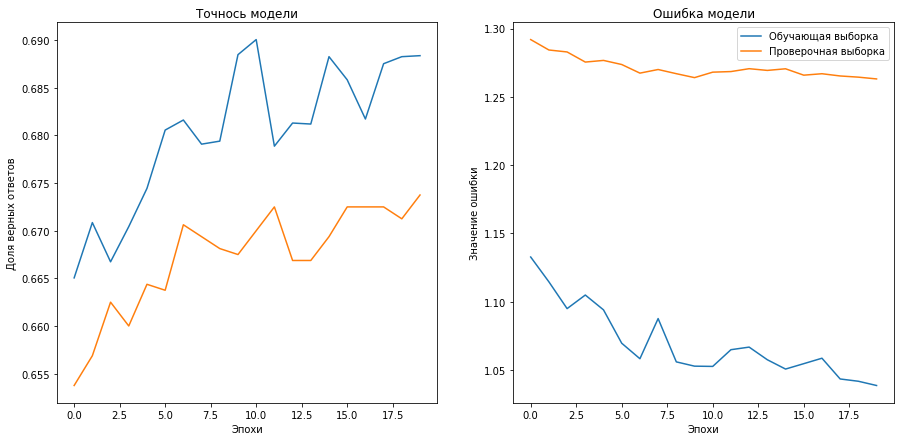

In [ ]:
#компиляция
model1.compile(optimizer=Adam(lr=1e-4),loss="sparse_categorical_crossentropy",metrics=["accuracy"])

#обучение
history1=model1.fit(xTrain,yTrain,
                    epochs=20,batch_size=20,
                    validation_data=(xTest,yTest))

draw(history1)

#Вывод

В данной работе была построена полносвязная нейронная сеть по классификации музыкальных инструментов с 2 скрытми слоями и с примененим 30-типроцетного dropout после каждого Dense-слоя. Для обучения и тестирования модели была использована  база данных FSDKaggle2018 с сэмплами для 41-го различного инструмента.Полученная точность на проверочной выборке равна 67.37%, график ошибки обучения имеет небольшой орицательный тренд, что говорит о возможности увеличения точности модели при уменьшении шага обучения. Также точность модели может улучшить более точный подбор архитектуры, гиперпарамеров и увеличение объема набора данных.